# One Day Internation History Dataset

With the Cricket World Cup 2019 just around the corner, what dataset could be more alluring to dig into than ODI matches history. This kernel attempts to squeeze some insights from the dataset.

Adding all the imports and path.

In [152]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import os
import time
from geopy.geocoders import Nominatim
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
from matplotlib.pyplot import pie
import pickle
import re

print(os.listdir("../input"))
INPUT_PATH = "../input/cricket-odi-dataset-from-cricinfo"
# DRIVE_PATH = "/content/drive/My Drive/ML_Training_Data"  # variable name is remnant of colab kernel
DRIVE_INPUT_PATH = "../input/glove-global-vectors-for-word-representation"  # variable name is remnant of colab kernel
print(os.listdir("../input/cricket-odi-dataset-from-cricinfo"))

['odi-dataset-from-cricinfo-with-geocoded-countries', 'glove-global-vectors-for-word-representation', 'cricket-odi-dataset-from-cricinfo']
['ODI_cricinfo_country_en.csv', 'ODI_cricinfo.csv']


All the functions defined here

In [153]:
# All methods in one place

def print_runtime(text, stime):
    delta = time.time() - stime
    print(text, int(delta//60), "minutes", ":", int(np.round(delta%60, 0)), 
          "seconds")
    
    
def fill_country(df, write_to_file=True, file_name="ODI_cricinfo_country.csv"):
    """
    Original dataset only had 'Ground' detail. This method was used to 
    fill the country where the match took place. Then the dataframe is saved as
    CSV for future usage.
    """
    city_country_map = None
    try:
        city_country_map = pickle.load(open(os.path.join(INPUT_PATH, "city_country_map"), "rb"))
    except:
        print("saved city country map not found")
        
    if city_country_map is None:
        print("Geocoding city to country...")
        city_country_map = {}
        cities = list(df["Ground"].unique()) 
        print("Fetching country for", len(cities), "cities")
        geolocator = Nominatim(user_agent="kaggle")
        c = 0
        for city in tqdm(cities):
            # print(c,city)
            city = re.sub(r"\(.*\)","",city).strip()
            location = geolocator.geocode(city, language='en')
            if location is not None:
                city_country_map[city] = (location.address.split(', ')[-1])
            else:
                print(c, city)
            c = c+1
            time.sleep(1)  # to avoid violating usage policy
        pickle.dump(city_country_map, open(os.path.join(INPUT_PATH, "city_country_map"), 'wb'))
    
    # now add these countries as column
    countries = [city_country_map[re.sub(r"\(.*\)","",city).strip()] 
                 for city in tqdm(df["Ground"])]
    print(len(df), len(countries))
    print(df["Ground"][:10], countries[:10])
    df["HostCountry"] = countries
    if write_to_file:
      print("Writing dataframe to CSV")
      df.to_csv(file_name)
      
    
def add_feature_value_fequencies(df_local, col1, col2):
    """
    This method adds the frequencies of each value of passed features of 
    given dataframe.
    
    return: dictionary --> with count of each value of passed features combined
    """
    team_series_temp = df_local.groupby(col1)[col1].aggregate("count")
    team1_dict = team_series_temp.to_dict()
    # print(team1_dict)
    team_series_temp = df_local.groupby(col2)[col2].aggregate("count")
    team2_dict = team_series_temp.to_dict()
    # print(team2_dict)
    return Counter(team1_dict)+Counter(team2_dict)
  

def generate_colors_random(no_of_colors):
    """
    This method generates colors with RGB compnents randomly
    
    return: list of tuples(R, G, B)
    """
    RGB_tuples = []
    for i in range(no_of_colors):
        temp = np.random.uniform(0, 1, 3)
        RGB_tuples.append((temp[0], temp[1], temp[2]))
    return RGB_tuples
  

def generate_colors_by_magnitude(values):
    """
    This method generates colors with RGB compnents proportional
    to numbers in the list passed as parameter
    
    return: list of tuples(R, G, B)
    """
    min_ = min(values)
    max_ = max(values)
    new_max = 1
    new_min = 0
    r = 0.8
    g = 0.7
    b = 0.0 # can be changed as per preference
    colors = []
    # NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
    for value in values:
        range_shifted_val = (((value - min_) * (new_max - new_min)) / 
                             (max_ - min_)) + new_min
        _r = r * range_shifted_val
        _g = g * (new_max - range_shifted_val)
        _b = _r * _g / 1.5
        colors.append((_r, _g, _b))
        
    return colors
  
    
def breakline_labels(labels):
    """
    replaces space in a text with new line.
    """
    short_labels = []
    for l in labels:
        short_labels.append(l.replace(" ","\n"))
    return short_labels

def shorten_labels(labels):
    """
    formats the labels to a more suitable size ideal for 
    displaying in plots.
    """
    short_labels = []
    for label in labels:
        final = ""
        if " " in label:
            words = label.split()
            for w in words:
                final = final + w[0]
        elif len(label) > 6:
             final = label[0:3]
        else:
            final = label
        short_labels.append(final)
    return short_labels
    

def swap_columns(row, col1, col2):
    """
    Function called for dataframe row. Passed row is sorted alphabetically on axis = 1
    i,e. column values are sorted.
    """
    
    if row[col1] > row[col2]:
        temp = row[col1]
        row[col1] = row[col2]
        row[col2] = temp
    return row

In [154]:
stime = time.time()

# IMPORTANT!
# This step is already done once. I have already saved the result as a new CSV 
# and it's accessible as new dataset "ODI_cricinfo_country_en.csv"

# df = pd.read_csv(os.path.join(INPUT_PATH, "ODI_cricinfo_country.csv"))
# fill_country(df, True, "ODI_cricinfo_country_en.csv")

df = pd.read_csv(os.path.join(INPUT_PATH, "ODI_cricinfo_country_en.csv"))
# pickle.dump(df, open("ODI_cricinfo_country.csv", 'wb'))
df.drop(labels = ["Unnamed: 0.1"], axis=1, inplace=True)
df.drop("Unnamed: 0", axis=1, inplace=True)
display(df.head(10))

print("Number of matches in dataset", len(df),"\n")
# Exploring null values
null_cols = df.isnull().any()
print("number of columns with null values", len(null_cols[null_cols]), "\n")
print("Columns with null values:", list(null_cols[null_cols].keys()), "\n")

teams = list(set(df["Team 1"]).union(set(df["Team 2"])))
print("Total number of teams", len(teams))
print(teams)

print_runtime("Cell 1 completed", stime)

,Scorecard,Team 1,Team 2,Winner,Margin,Ground,Match Date,HostCountry
0,ODI # 1,Australia,England,Australia,5 wickets,Melbourne,"Jan 5, 1971",Australia
1,ODI # 2,England,Australia,England,6 wickets,Manchester,"Aug 24, 1972",United Kingdom
2,ODI # 3,England,Australia,Australia,5 wickets,Lord's,"Aug 26, 1972",India
3,ODI # 4,England,Australia,England,2 wickets,Birmingham,"Aug 28, 1972",United Kingdom
4,ODI # 5,New Zealand,Pakistan,New Zealand,22 runs,Christchurch,"Feb 11, 1973",New Zealand
5,ODI # 6,England,New Zealand,England,7 wickets,Swansea,"Jul 18, 1973",United Kingdom
6,ODI # 7,England,New Zealand,no result,NaN,Manchester,"Jul 20, 1973",United Kingdom
7,ODI # 8,England,West Indies,England,1 wicket,Leeds,"Sep 5, 1973",United Kingdom
8,ODI # 9,England,West Indies,West Indies,8 wickets,The Oval,"Sep 7, 1973",United Kingdom
9,ODI # 10,New Zealand,Australia,Australia,7 wickets,Dunedin,"Mar 30, 1974",New Zealand


Number of matches in dataset 4124 

number of columns with null values 1 

Columns with null values: ['Margin'] 

Total number of teams 27
['P.N.G.', 'Kenya', 'Namibia', 'Zimbabwe', 'Netherlands', 'Canada', 'Sri Lanka', 'England', 'East Africa', 'U.A.E.', 'Asia XI', 'Africa XI', 'U.S.A.', 'Pakistan', 'West Indies', 'New Zealand', 'ICC World XI', 'South Africa', 'Bermuda', 'Hong Kong', 'Ireland', 'Nepal', 'Australia', 'Scotland', 'Bangladesh', 'Afghanistan', 'India']
Cell 1 completed 0 minutes : 0 seconds


Let's check the data types of dataframe columns.

In [155]:
print(df.dtypes)

Scorecard      object
Team 1         object
Team 2         object
Winner         object
Margin         object
Ground         object
Match Date     object
HostCountry    object
dtype: object


We need to convert "Match Date" to 'datetime' type. But there are some values in "Match Date" column that don't follow the consistent format like shown below. I have also shown  how to convert it to proper format.

In [156]:
count = 0
for date in tqdm(df["Match Date"]):
    if not re.match("[A-Za-z]{3}\s\d{1,2},\s\d{4}", date):
        print(date, "<===>" ,re.sub("\d{1,2}-","", date))
        count = count + 1
        if count > 10:
            break

Jul 15-16, 1974 <===> Jul 16, 1974
Aug 28-29, 1976 <===> Aug 29, 1976
Aug 30-31, 1976 <===> Aug 31, 1976
May 24-25, 1978 <===> May 25, 1978
Jun 13-14, 1979 <===> Jun 14, 1979
Jun 13-14, 1979 <===> Jun 14, 1979
Jun 16-18, 1979 <===> Jun 18, 1979
May 28-29, 1980 <===> May 29, 1980
Jun 9-10, 1983 <===> Jun 10, 1983
Jun 11-12, 1983 <===> Jun 12, 1983
Jun 11-12, 1983 <===> Jun 12, 1983



But we can reformat the date strings in a better way like this:

In [157]:
df["Match Date"] = df["Match Date"].str.replace("\d{1,2}-","")

Now we can convert the datatype of "Match Date" column.

In [158]:
print("Before conversion dtype:", df["Match Date"].dtype)
df["Match Date"] = pd.to_datetime(df["Match Date"], format='%b %d, %Y')
print("After conversion dtype:", df["Match Date"].dtype)
display(df.head(10))

Before conversion dtype: object
After conversion dtype: datetime64[ns]


,Scorecard,Team 1,Team 2,Winner,Margin,Ground,Match Date,HostCountry
0,ODI # 1,Australia,England,Australia,5 wickets,Melbourne,1971-01-05,Australia
1,ODI # 2,England,Australia,England,6 wickets,Manchester,1972-08-24,United Kingdom
2,ODI # 3,England,Australia,Australia,5 wickets,Lord's,1972-08-26,India
3,ODI # 4,England,Australia,England,2 wickets,Birmingham,1972-08-28,United Kingdom
4,ODI # 5,New Zealand,Pakistan,New Zealand,22 runs,Christchurch,1973-02-11,New Zealand
5,ODI # 6,England,New Zealand,England,7 wickets,Swansea,1973-07-18,United Kingdom
6,ODI # 7,England,New Zealand,no result,NaN,Manchester,1973-07-20,United Kingdom
7,ODI # 8,England,West Indies,England,1 wicket,Leeds,1973-09-05,United Kingdom
8,ODI # 9,England,West Indies,West Indies,8 wickets,The Oval,1973-09-07,United Kingdom
9,ODI # 10,New Zealand,Australia,Australia,7 wickets,Dunedin,1974-03-30,New Zealand


Now we will take care of null values. From first cell output we know that "Margin" column has null values. Margin represents by what margin the team won. In most the of the cases "Margin" is null if match was a tie or "no result". But let'verify this assumption.

In [159]:
if len(null_cols) > 0:
    df_na = df[df.isnull().any(axis=1)]
    print("Unique values in 'Winner column'", df_na["Winner"].unique(),"\n")
    print("checking for matches where Margin is null but Winner has some value--\n")
    display(df_na[(df_na["Winner"] != "no result") & (df_na["Winner"] != "tied")])
    
    print("\nNumber of records with null values", len(df_na), "which is", 
          np.round((len(df_na)/len(df))*100, 2), "% of total data\n")
    null_team_counts = add_feature_value_fequencies(df_na, "Team 1", "Team 2")
    # print(null_team_counts)

Unique values in 'Winner column' ['no result' 'Pakistan' 'tied' 'India' 'Sri Lanka'] 

checking for matches where Margin is null but Winner has some value--



,Scorecard,Team 1,Team 2,Winner,Margin,Ground,Match Date,HostCountry
55,ODI # 56,Pakistan,India,Pakistan,NaN,Sahiwal,1978-11-03,Pakistan
435,ODI # 436,India,Pakistan,India,NaN,Hyderabad (Deccan),1987-03-20,India
521,ODI # 522,Pakistan,Australia,Pakistan,NaN,Lahore,1988-10-14,Pakistan
1080,ODI # 1081,India,Sri Lanka,Sri Lanka,NaN,Kolkata,1996-03-13,India
1723,ODI # 1724,England,Pakistan,Pakistan,NaN,Leeds,2001-06-17,United Kingdom



Number of records with null values 186 which is 4.51 % of total data



As we saw above there are 6 matches with null value in "Margin" but have winner declared. We can check the news and check what happened. I did that for first few matches. They turned out be special cases like "opposition conceded" (whatever that means) and "fewer wicket lost" etc. Now let's see **which teams were most affected by these wierd cases**, so that while analysing the dataset we 
can keep

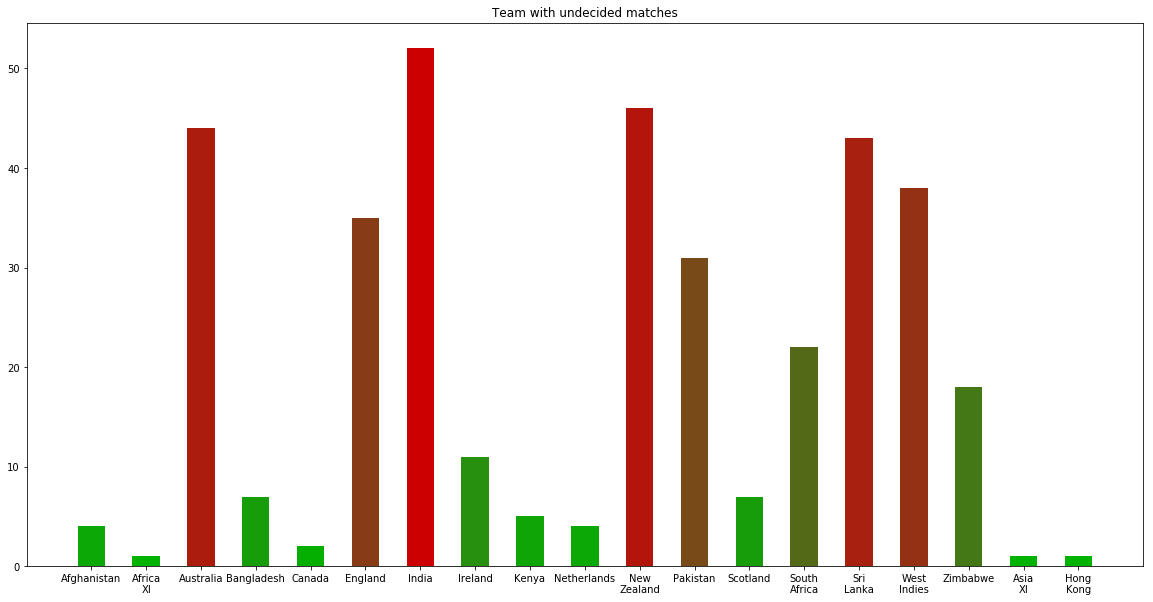

In [160]:
if null_team_counts is not None:
    null_team_counts = dict(null_team_counts)
    plt.figure(figsize=(20, 10))
    plt.bar(breakline_labels(list(null_team_counts.keys())), 
            null_team_counts.values(), width=0.5, align='center', 
            color=generate_colors_by_magnitude(null_team_counts.values()))
    plt.title("Team with undecided matches")
    plt.show()


Unfortunately India has highest number of undecided matches, followed by New Zealand, Sri Lanka, Australia. Now, what if we wanted to know **which team has maximum number of undecided matches with India?**

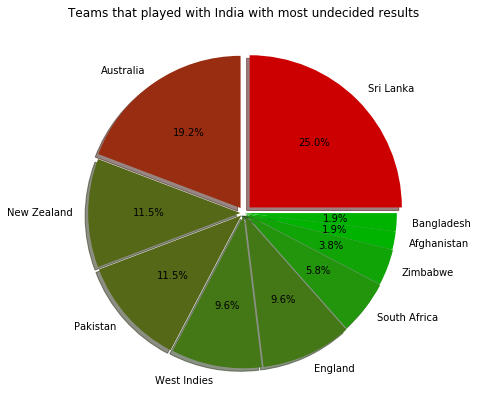

In [161]:
df_temp = df_na[(df_na["Team 1"]=="India") | (df_na["Team 2"]=="India")]

# To find which team has highest undecided result with India we can swap 'Team 1'
# and 'Team 2' values such that 'Team 1' has only "India" string, so that we 
# do a groupby and find frequency of each team in 'Team 2'
pd.options.mode.chained_assignment = None # suppress copy warning for this op

bool_mask = df_temp["Team 2"] == "India"
swap_val = df_temp.loc[bool_mask]["Team 1"]
df_temp.loc[bool_mask, ["Team 1"]] = "India"
df_temp.loc[bool_mask, ["Team 2"]] = swap_val
opponents = df_temp["Team 2"].value_counts()

pd.options.mode.chained_assignment = "warn"  # reset copy warning for this op

plt.figure(figsize=(10, 7))
pie(opponents, labels=list(opponents.keys()), explode=opponents*0.004,
    colors=generate_colors_by_magnitude(opponents), shadow=True, autopct='%1.1f%%')
plt.title("Teams that played with India with most undecided results")
plt.show()

Okay, enough with null values. Let's look into other aspects of the data. Let's see **which teams are invincible on there home grounds**

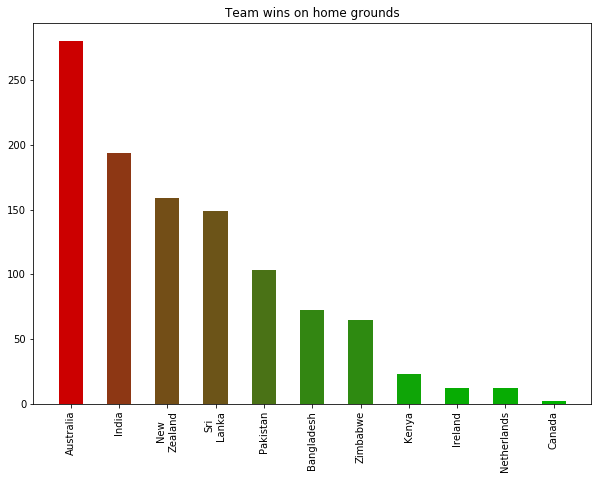

In [162]:
df_temp = df[df["Winner"] == df["HostCountry"]]
host_winners = df_temp["Winner"].value_counts()

plt.figure(figsize=(10, 7))
plt.bar(breakline_labels(list(host_winners.keys())), 
        host_winners, width=0.5, align='center', 
        color=generate_colors_by_magnitude(host_winners))
plt.xticks(rotation='vertical')
plt.title("Team wins on home grounds")
plt.show()

Clearly Australia seems invincible in Australian grounds followed by India. Intrestingly, we see only 11 teams here out of 27. So there are **16 teams which have not won a single match on there home grounds yet!** Let's find them.

In [163]:
zero_home_winners = list(set(teams).difference(set(host_winners.keys())))
print(zero_home_winners)

['England', 'P.N.G.', 'East Africa', 'U.A.E.', 'Asia XI', 'Africa XI', 'Namibia', 'U.S.A.', 'West Indies', 'South Africa', 'Bermuda', 'Scotland', 'Hong Kong', 'Afghanistan', 'ICC World XI', 'Nepal']


If you observe the above result, we see that England has not won any matches on it's home ground! Obviously that's not right. Let's check match records for these above teams.

In [164]:
display(df[ df["Team 1"].isin(zero_home_winners) | df["Team 2"].isin(zero_home_winners) ].head(10))

,Scorecard,Team 1,Team 2,Winner,Margin,Ground,Match Date,HostCountry
0,ODI # 1,Australia,England,Australia,5 wickets,Melbourne,1971-01-05,Australia
1,ODI # 2,England,Australia,England,6 wickets,Manchester,1972-08-24,United Kingdom
2,ODI # 3,England,Australia,Australia,5 wickets,Lord's,1972-08-26,India
3,ODI # 4,England,Australia,England,2 wickets,Birmingham,1972-08-28,United Kingdom
5,ODI # 6,England,New Zealand,England,7 wickets,Swansea,1973-07-18,United Kingdom
6,ODI # 7,England,New Zealand,no result,NaN,Manchester,1973-07-20,United Kingdom
7,ODI # 8,England,West Indies,England,1 wicket,Leeds,1973-09-05,United Kingdom
8,ODI # 9,England,West Indies,West Indies,8 wickets,The Oval,1973-09-07,United Kingdom
11,ODI # 12,England,India,England,4 wickets,Leeds,1974-07-13,United Kingdom
12,ODI # 13,England,India,England,6 wickets,The Oval,1974-07-16,United Kingdom


You see, we have erred--gravely! There are some teams for which team name and country names (found from Geopy) differ. How do you think we can solve this predicament? First we need to filter out the teams which have different country names returned by Geopy. To find them I have found team names that are not present in "HostCountry" and vice versa. But these are just possible mismatches: meaning-- It's possible that "Nepal" team has zero mentions in "HostCountry" because it has not played/won any matches in home ground and not because it's official name returns by Geopy is different.

In [165]:
# teams that are not present in HostCountry
differing_team_country = list(set(teams).difference(set(df["HostCountry"]))) 
# HostCountry values that are not present in teams
differing_team_country2 = list(set(df["HostCountry"]).difference(set(teams)))

print("Teams =",differing_team_country) # 15
print("HostCountries =", differing_team_country2) # 20

# most_similar_to_given

Teams = ['England', 'P.N.G.', 'East Africa', 'U.A.E.', 'Asia XI', 'Africa XI', 'Namibia', 'U.S.A.', 'West Indies', 'South Africa', 'Scotland', 'Hong Kong', 'Afghanistan', 'ICC World XI', 'Nepal']
HostCountries = ['Jamaica', 'Saint Vincent and the Grenadines', 'Dominica', 'Papua New Guinea', 'RSA', 'Trinidad and Tobago', 'Saint Kitts and Nevis', 'Cayman Islands', 'PRC', 'United Kingdom', 'Saint Lucia', 'France', 'Malaysia', 'Singapore', 'Barbados', 'United Arab Emirates', 'USA', 'Japan', 'Morocco', 'Belgium']


There are some teams that are insignificant for our purpose here like "ICC World XI", "East Africa". Let's drop them. 

In [166]:
teams_to_drop = ["Asia XI", "East Africa", "Nepal", 'ICC World XI', 'Africa XI']
for d in teams_to_drop:
    try:
        differing_team_country.remove(d)
    except:
        print(d, "not in list")
    
print(differing_team_country)

['England', 'P.N.G.', 'U.A.E.', 'Namibia', 'U.S.A.', 'West Indies', 'South Africa', 'Scotland', 'Hong Kong', 'Afghanistan']


To solve this we can try using NLP concepts (specifically WordVectors). Word Vectors are vector representation of each word. Hence, vector similarity finding methods can be used connect similar words. For example word "England" should be more similar to "United Kingdom" than "China" (theoretically ofcourse). And to do that I will use the Glove pre-trained word vectors in Gensim model. Glove vectors were found after training on huge text corpus, so we can expect it to capture true relations between words. Let's test our assumption. We have to first load the Glove data into Gensim like this:

In [167]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

stime = time.time()
glove_file = "glove.6B.200d.txt"
print("converting Glove to Word2Vec")
glove2word2vec(glove_input_file=os.path.join(DRIVE_INPUT_PATH, glove_file), word2vec_output_file="gensim_glove_vectors.txt")
print("loading Word2Vec")
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)
print_runtime("loading done", stime)  # took approx. 1.5 min

converting Glove to Word2Vec
loading Word2Vec
loading done 1 minutes : 25 seconds


Checking if the model is trust worthy :

In [168]:
word1 = "america"
word2 = "usa"

print("Similarity between", word1, "&",word2, "is", glove_model.similarity(word1, word2))

word1 = "america"
word2 = "jupiter"

print("Similarity between", word1, "&",word2, "is", glove_model.similarity(word1, word2))

word1 = "man"
word2 = "human"

print("Similarity between", word1, "&",word2, "is", glove_model.similarity(word1, word2))

word1 = "man"
word2 = "kangaroo"

print("Similarity between", word1, "&",word2, "is", glove_model.similarity(word1, word2))

Similarity between america & usa is 0.52149886
Similarity between america & jupiter is 0.107206546
Similarity between man & human is 0.42945758
Similarity between man & kangaroo is 0.14758587


I have hashed out a quick & dirty code to put word vectory to test and see if it works well for countries and their abbreviations. For each team I have printed top (at most) 5  matching country names.  

In [169]:
scores = {}
for w1 in differing_team_country:  # teams
    w1s = w1.replace('.', '').lower().split()

    # print("w1s",w1s)

    for w2 in differing_team_country2:  # countries
        w2s = w2.replace('.', '').lower().split()
        sim = 0
        for x in w1s:
            for y in w2s:
                try:
                    res = glove_model.similarity(x, y)
                    # print(x,"<-->", y, res)
                    sim = sim + res
                except:
                    # print(w, "not found")
                    pass
        scores[(w1, w2)] = sim
        # print((w1, w2), scores[(w1,w2)])

for team in differing_team_country:
    list_team_scores = []
    list_team_hosts = []
    for t in scores:
        if t[0] == team:
            list_team_scores.append(scores[t])
            list_team_hosts.append(t[1])
    _ = sorted(range(len(list_team_scores)),
               key=list_team_scores.__getitem__, reverse=True)
    for i in _[:5]:
        print (team, '&', list_team_hosts[i], '=', list_team_scores[i])
    print('-----------------------------------------------------------------------')


England & Saint Vincent and the Grenadines = 1.3496581204235554
England & Trinidad and Tobago = 0.9625848233699799
England & Saint Kitts and Nevis = 0.9550003036856651
England & United Arab Emirates = 0.8915860503911972
England & United Kingdom = 0.8546380400657654
-----------------------------------------------------------------------
P.N.G. & Papua New Guinea = 1.2385173365473747
P.N.G. & Saint Vincent and the Grenadines = 0.6404824629426003
P.N.G. & Trinidad and Tobago = 0.4996645376086235
P.N.G. & Saint Kitts and Nevis = 0.4838756024837494
P.N.G. & Cayman Islands = 0.3800114393234253
-----------------------------------------------------------------------
U.A.E. & United Arab Emirates = 1.8266726732254028
U.A.E. & Trinidad and Tobago = 0.7127024233341217
U.A.E. & United Kingdom = 0.7104402482509613
U.A.E. & Saint Vincent and the Grenadines = 0.6236486909911036
U.A.E. & Malaysia = 0.5387277007102966
-----------------------------------------------------------------------
Namibia & Pap

As you can see, it worked well for "U.S.A.", "U.A.E.", "West Indies" (as it matched with most of it's constituent islands), "P.N.G.". But it failed miserably for "England" (should have been United Kingdom), "South Africa" (expected RSA), and "Hong Kong" (expected PRC). Rest of countries like Namibia, Scotland etc had no matching names in the list anyways, so let's leave them out of consideration. 

Final verdict is WordVectors can't be trusted here (although one of the reasons for it's bad result could be that I am adding similarity of all words for e.g., for England & United Arab Emirates, similarity is (England, United) + (England, Arab) + (England, Emirates) and we can only consider the similarity if each of the pair is larger than a certain threshold, say 0.2).

So for now I will replace the "HostCountry" names with respective team names manually, since 'difference' list is quite small. But for larger lists it's not possible. I will update the article if I find any better way. Here is what the "HostCountry" should be replaced with. For instance "United Arab Emir." would be replaced with "U.A.E.".

```
Team         Host
---------------------------------
U.A.E        United Arab Emirates
England      United Kingdom
West Indies  Saint Lucia, Cayman Islands, Jamaica, Saint Vincent And Grenadines, Trinidad Tobago, Barbados, Saint                                Kitts and Nevis, Dominica, Bermuda     
Asia XI      removed
South Afric  RSA
P.N.G.       Papua New Guinea
East Africa  removed
Nepal .      -
U.S.A.       USA
Namibia .    -
Afghanistan  -
Hong Kong    PRC (not sure if correct)
Africa XI    removed
ICC XI       removed
scotland     -
```

In [170]:
values = ["U.A.E.", "England", "South Africa", "P.N.G.", "U.S.A.", "Hong Kong"]
to_replace = ["United Arab Emirates", "United Kingdom",
             "RSA", "Papua New Guinea", "USA", "PRC"]
df["HostCountry"].replace(to_replace, values, inplace=True)
df["HostCountry"].replace( ["Saint Lucia", "Cayman Islands", 
                           "Jamaica", 'Saint Vincent and the Grenadines', 
                            "Trinidad Tobago", "Barbados", 
                            "Saint Kitts and Nevis", "Dominica"], "West Indies",
                          inplace=True)
print("Unique values in HostCountry column now--\n",df["HostCountry"].unique())

Unique values in HostCountry column now--
 ['Australia' 'England' 'India' 'New Zealand' 'Pakistan' 'Canada'
 'West Indies' 'Sri Lanka' 'Trinidad and Tobago' 'Bermuda' 'U.A.E.'
 'U.S.A.' 'Bangladesh' 'France' 'Zimbabwe' 'South Africa' 'Singapore'
 'Kenya' 'Japan' 'Belgium' 'Ireland' 'Netherlands' 'Morocco' 'Malaysia'
 'Hong Kong' 'P.N.G.']


Since Country names issue seems to be resolved, let's revisit the home vs overseas win question.

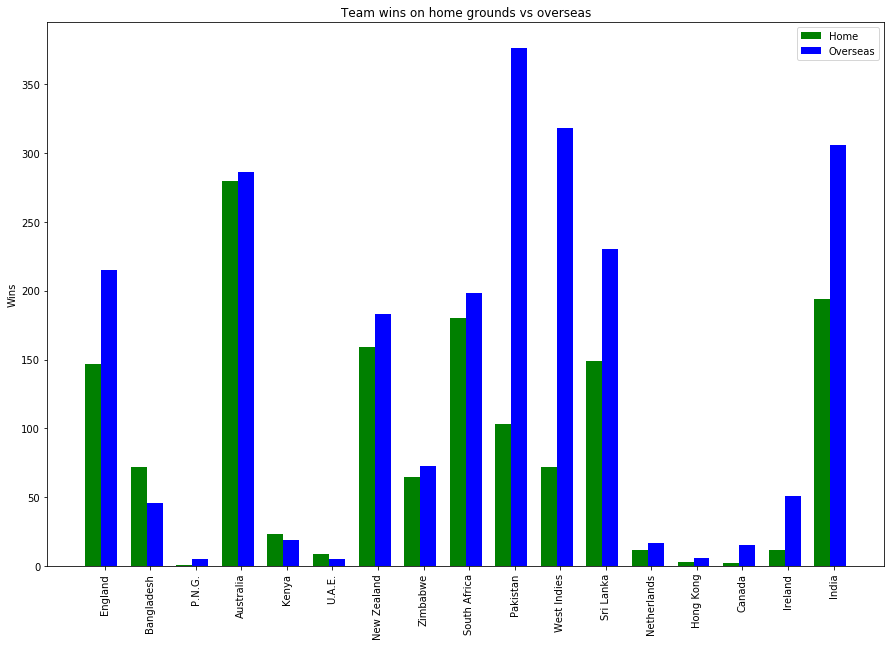

103


In [171]:
df_temp = df[df["Winner"] == df["HostCountry"]]
host_winners = df_temp["Winner"].value_counts()
host_winners.sort_values(inplace=True, ascending=False)

df_temp = df[df["Winner"] != df["HostCountry"]]
guest_winners = df_temp["Winner"].value_counts()
guest_winners.sort_values(inplace=True, ascending=False)

inds = list(set(host_winners.keys()).intersection(set(guest_winners.keys())))
# print(inds)

hw_vals = host_winners[inds]
gw_vals = guest_winners[inds]
# print("hw_vals\n", hw_vals)
# print("gw_vals\n", gw_vals)

width = 0.35
plt.figure(figsize=(15, 10))
plt.bar(np.arange(len(inds)), #breakline_labels(list(host_winners.keys())) 
        hw_vals[inds], width=width, align='center', 
        color='g')


plt.bar(np.arange(len(inds))+width, 
        gw_vals[inds], width=width, align='center', 
        color='b')

# print(len(host_winners), len(guest_winners))
plt.xticks(np.arange(len(inds))+0.5/2, inds)
plt.title("Team wins on home grounds vs overseas")
plt.ylabel("Wins")
plt.xticks(rotation='vertical')
plt.legend(["Home", "Overseas"])
plt.show()

# print(host_winners["Pakistan"])

Australia is still way ahead of other teams on home ground wins. But Pakistan seems to be doing exceptionally well on overseas matches. 
Next question that comes to mind is **"how has the number of ODIs played per year changed over the years?"**

In [172]:
df["year"] = df["Match Date"].apply(lambda x: x.year)
# display(df[["Match Date", "year"]].head())

**Number of matches played each year since 1971 are:**

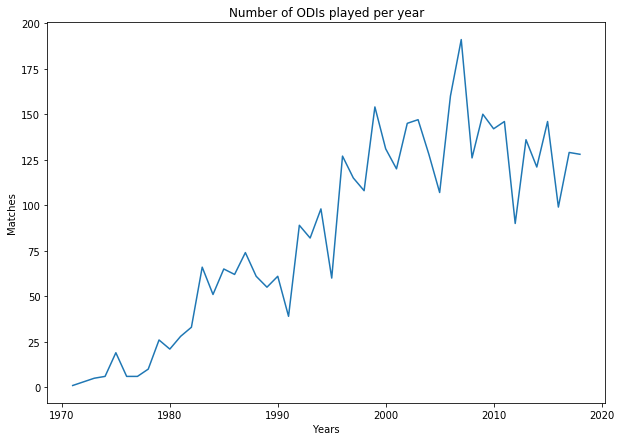

In [173]:
matches_per_year = df["year"].value_counts()
matches_per_year.sort_index(inplace=True)

plt.figure(figsize = (10, 7))
plt.title("Number of ODIs played per year")
plt.plot(matches_per_year.keys()[:-1], matches_per_year[:-1])  # leave 2019 
plt.xlabel("Years")
plt.ylabel("Matches")
plt.show()

**Which teams have faced off each other most number of times?**

This what origin data looks like. To be able to count number of times each pair of teams have played I will sort the order of team columns.


,Team 1,Team 2
0,Australia,England
1,England,Australia
2,England,Australia
3,England,Australia
4,New Zealand,Pakistan


Sorted values on axis = 1


,Team 1,Team 2
0,Australia,England
1,Australia,England
2,Australia,England
3,Australia,England
4,New Zealand,Pakistan


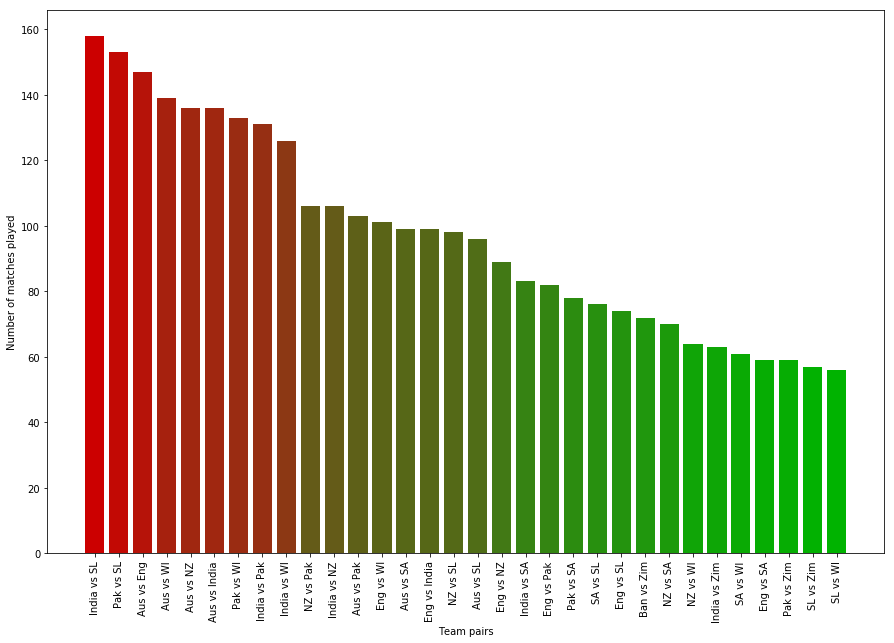

In [174]:
df_temp = df[["Team 1", "Team 2"]]
print("This what origin data looks like. To be able to count number of times each pair of teams have played I will sort the order of team columns.")
display(df_temp.head())
df_temp.apply(lambda row: swap_columns(row, "Team 1", "Team 2"), axis=1)
print("Sorted values on axis = 1")
display(df_temp.head())

# now we can groupby Team 1 and Team 2
df_temp = df_temp.groupby(["Team 1", "Team 2"]).size().reset_index(name="count")  # [["Team 1", "Team 2"]].aggregate("count")
df_temp.sort_values("count", inplace=True, ascending=False)
df_temp = df_temp[df_temp["count"] > 50]

plt.figure(figsize=(15, 10))
x_ticks = ["{} vs {}".format(t1, t2) for t1, t2, in zip(shorten_labels(df_temp["Team 1"]), shorten_labels(df_temp["Team 2"]))]
plt.bar(x_ticks, df_temp["count"], color=generate_colors_by_magnitude(df_temp["count"]))
plt.xticks(rotation='vertical')
plt.xlabel("Team pairs")
plt.ylabel("Number of matches played")
plt.show()

# To be continued...